## Load data

In [1]:
import numpy as np
import _pickle as pkl
import torch
import torch.nn as nn
from torchvision import transforms
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray
set_seed_torch(3)
from argparse import Namespace
import json
from utils import load_models, load_vh_models, frame_stack

In [9]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({'res': 64,
 'dataset_path': '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("visual_haptic_2D_len16_osc_withGT_8C12919B740845539C0E75B5CBAF7965.pkl"),
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("vaughan/osc/"),
 'device': 'cuda:0',
 'n_examples': 5,
 'n_pred': 8,
})

def load_models_dir(models_dir):
    """Load hyperparameters from trained model."""
    dict_of_models = {}
    for filedir in os.listdir(models_dir):
        fullpath = os.path.join(models_dir, filedir)
        if os.path.isdir(fullpath):
            with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
                dict_of_models[fullpath] = Namespace(**json.load(fp))
    return dict_of_models

In [7]:
with open(args.dataset_path, 'rb') as f:
    raw_data = pkl.load(f)

data = {}
data['img_rgb'] = torch.from_numpy(raw_data["img"].transpose(0, 1, 4, 2, 3)).int().to(device=args.device)
data['img_gray'] = torch.from_numpy(rgb2gray(raw_data["img"]).transpose(0, 1, 4, 2, 3)).float().to(device=args.device)
data['haptic'] = torch.from_numpy(raw_data['ft']).float().to(device=args.device) / 100.0
data['arm'] = torch.from_numpy(raw_data['arm']).float().to(device=args.device)

actions = torch.from_numpy(raw_data["action"]).to(device=args.device).float()

## Visualize

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/z16_net512_l0_lm_ul_osc_v_r0.95_kl0.80_lr3e4
torch.Size([5, 9, 16])
(5, 9, 2, 64, 64) (5, 10, 1, 64, 64)
MSE of predictions:  [0.23117228 0.35563967 0.38729623 0.8099646  0.7465095  1.1381463
 1.0460955  1.3918781 ]


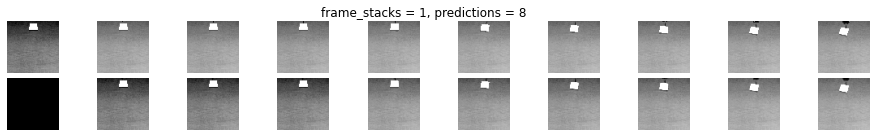

MSE of predictions:  [0.21926208 0.35677606 1.0894866  2.3946521  4.35239    3.8169081
 6.342336   7.9318876 ]


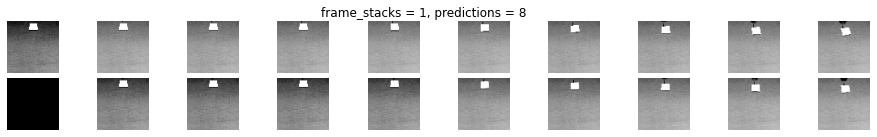

MSE of predictions:  [ 0.28078628  0.4216361   2.1101675   5.743631    7.596643   11.4044695
 15.848055   21.14656   ]


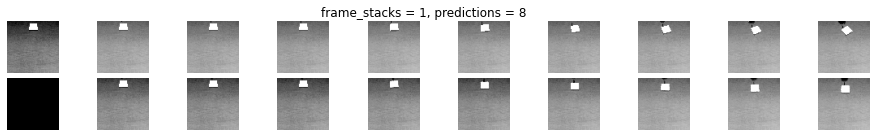

MSE of predictions:  [ 0.24669646  0.44483307  1.8435326   3.1743653   3.8024888   9.64477
 14.625322   18.983398  ]


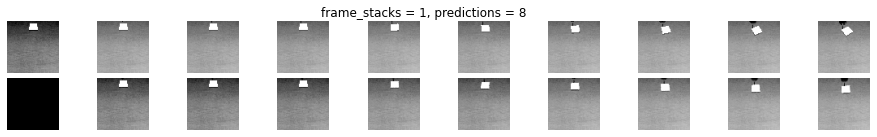

MSE of predictions:  [ 0.11049952  0.41314176  2.5503843   3.2774613   6.124914   11.761715
 17.24703    22.823128  ]


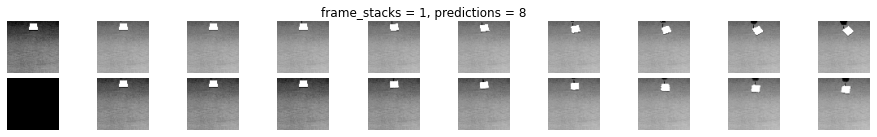

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/z16_net512_l0_lm_osc_vha_r0.95_kl0.80_lr3e4
torch.Size([5, 9, 16])
(5, 9, 2, 64, 64) (5, 10, 1, 64, 64)
MSE of predictions:  [ 0.57701755  4.22663     2.588239    5.4460793   8.242193   13.01833
 20.001738   28.878698  ]


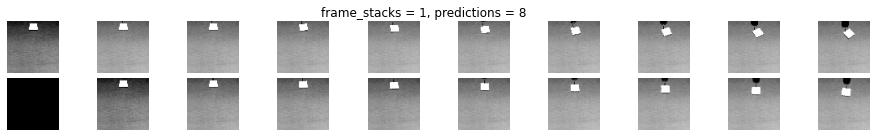

MSE of predictions:  [0.0276535 2.433057  0.6340502 1.4092366 1.1926643 3.2189376 4.076632
 5.5439157]


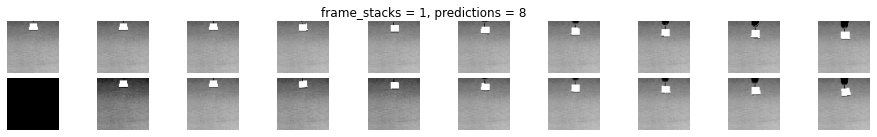

MSE of predictions:  [ 0.9812284  1.7982986  3.4043658  4.2701726  8.86344   12.332467
 18.660149  20.567472 ]


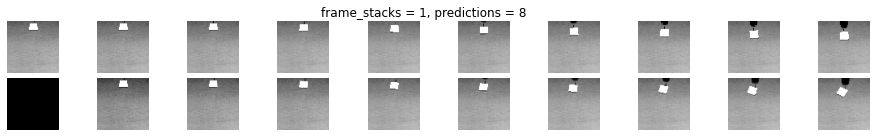

MSE of predictions:  [0.44882908 0.65932274 3.0481875  1.7955998  3.5110893  4.1455884
 3.2349632  2.7142994 ]


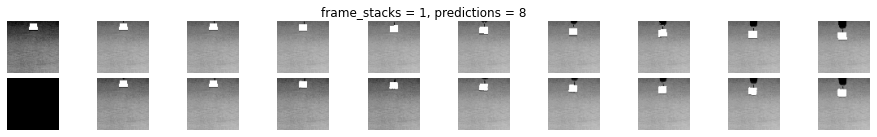

MSE of predictions:  [ 0.57107717  2.224821    2.6795757   4.5391946   8.4173     10.9497175
 12.337421   15.206118  ]


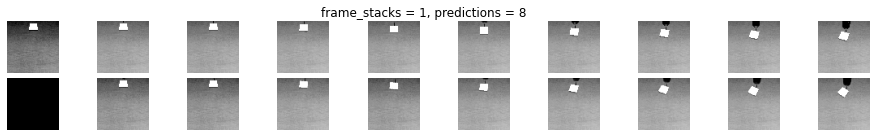

In [13]:
dict_of_models = load_models_dir(args.models_dir)

with torch.no_grad():
    for path, model_args in dict_of_models.items():
            
        nets = load_vh_models(path=path, args=model_args, mode='eval', device=args.device)

        if model_args.dim_x[0] == 1:
            imgs = data['img_gray']
        elif model_args.dim_x[0] == 3:
            imgs = data['img_rgb']
        
        total_len = imgs.shape[1]
        T = model_args.frame_stacks
        
        ii = np.random.randint(imgs.shape[0] // args.n_examples)
        batch_range = range(args.n_examples*ii, args.n_examples*(ii+1))
        start_idx = 0
        
        x = imgs[:, start_idx:][batch_range, :(T + 1 + args.n_pred)]
        x_i = imgs[:, start_idx:][batch_range, :(T + 1)] 
        x_i = frame_stack(x_i, frames=T)[:, 0] 

        if model_args.context=="initial_latent_state":
            ctx_img_i = x_i   

        x_ft_i = data['haptic'][:, start_idx:][batch_range, T:(T + 1)]
        x_arm_i = data['arm'][:, start_idx:][batch_range, T:(T + 1)]

        u = actions[:, start_idx:][
            batch_range, 
            (T + 1):(T + 1 + args.n_pred)
        ] 
            
        # Roll-out or predictions
        if model_args.context_modality != "none":
            if model_args.context_modality == "joint": 
                ctx_i = torch.cat((x_ft_i, x_arm_i), dim=-1) # (n, l, f, 12)
            elif model_args.context_modality == "ft": 
                ctx_i = x_ft_i
            elif model_args.context_modality == "arm":
                ctx_i = x_arm_i
            ctx_i = ctx_i.float().to(device=args.device) # (n, l, f, 6)
            ctx_i = ctx_i.transpose(-1, -2)
            ctx_i = ctx_i.reshape(-1, *ctx_i.shape[2:])  

        # Encode
        z_all_enc = []

        z_img = nets["img_enc"](x_i)
        z_all_enc.append(z_img)              

        if model_args.context_modality != "none":
            z_context = nets["context_enc"](ctx_i)
            z_all_enc.append(z_context)
        if model_args.context=="initial_latent_state":
            z_img_context = nets["context_img_enc"](ctx_img_i)
            z_all_enc.append(z_img_context)

        # Concatenate modalities and mix
        z_cat_enc = torch.cat(z_all_enc, dim=1)
        z_i, mu_z_i, logvar_z_i = nets["mix"](z_cat_enc)
        var_z_i = torch.diag_embed(torch.exp(logvar_z_i))
        h_i = None

        z_hat = torch.zeros((args.n_examples, (1 + args.n_pred), model_args.dim_z)).to(device=args.device)
        z_hat[:, 0] = z_i
        
        # Predict
        for jj in range(args.n_pred):
            z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = nets["dyn"](
                z_t=z_i, 
                mu_t=mu_z_i, 
                var_t=var_z_i, 
                u=u[:, jj], 
                h_0=h_i, 
                single=True
            )

            z_hat[:, jj + 1] = mu_z_ip1
            z_i, mu_z_i, var_z_i, h_i = z_ip1, mu_z_ip1, var_z_ip1, h_ip1    
                    
        # Decode
        z_all_dec = []
        z_all_dec.append(z_hat)

        if model_args.context=="initial_latent_state" or model_args.context=="goal_latent_state":
            z_img_context_rep = z_img_context.unsqueeze(1).repeat(1, (args.n_pred + 1), 1)
            z_all_dec.append(z_img_context_rep)
        
        z_cat_dec = torch.cat(z_all_dec, dim=-1)
        
        x_hat = nets["img_dec"](z_cat_dec.reshape(-1, *z_cat_dec.shape[2:]))
        x_hat = x_hat.reshape(args.n_examples, (args.n_pred + 1), *x_hat.shape[1:])

        # Move to cpu, np
        x_hat = x_hat.cpu().numpy()
        x = x.cpu().numpy()

        mse = np.sum((x_hat[:, 1:, 0].reshape(args.n_examples, args.n_pred, -1) - 
                      x[:, 2:, 0].reshape(args.n_examples, args.n_pred, -1))**2, axis=2)

        # Plotting
        for bb in range(args.n_examples):
            columns = T + 1 + args.n_pred
            rows = 2
            fig=plt.figure(figsize=(16, 2))
            fig.suptitle('frame_stacks = {}, predictions = {}'.format(T, args.n_pred))
            for ii in range(columns*rows):
                if ii<((columns*rows)/2):
                    img = x[bb,ii,0,:,:]
                else:
                    idx = int(ii-((columns*rows)/2))
                    if idx < T:
                        img = np.zeros((model_args.dim_x[1], model_args.dim_x[2]))
                    else:
                        img = x_hat[bb,idx-1,0,:,:]
                fig.add_subplot(rows, columns, ii+1)
                plt.imshow(img, cmap="gray")
                
                plt.axis('off')
            print("MSE of predictions: ", mse[bb])
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            plt.show()